In [1]:
!git clone https://github.com/Rishikesh-Jadhav/Track_Deep_Learning

Cloning into 'Track_Deep_Learning'...
remote: Enumerating objects: 17020, done.
remote: Total 17020 (delta 0), reused 0 (delta 0), pack-reused 17020
Receiving objects: 100% (17020/17020), 245.61 MiB | 14.67 MiB/s, done.
Updating files: 100% (17017/17017), done.


In [2]:
!ls

sample_data  Track_Deep_Learning


In [3]:
!ls Track_Deep_Learning/

driving_log.csv  IMG


In [4]:
# Till now we have created the dataset from the simulator 3 laps front  and 3 laps reverse so the model doesnt become left turn bias as our track consists majorly of left turns

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import pandas as pd
import cv2
import random
import os # module helpful for path inclusion instead of specifying string path
import ntpath # to split path
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

%matplotlib inline

In [6]:
data_directory = 'Track_Deep_Learning'
columns = ['center','left','right','steering','throttle','reverse','speed']
df = pd.read_csv(os.path.join(data_directory,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
df.head(5) # column overflows and we need to see full path


<ipython-input-6-17b2f0ce6025>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\center_2023_02_13_14_28_29_922.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\left_2023_02_13_14_28_29_922.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\right_2023_02_13_14_28_29_922.jpg,0.0,0.0,0.0,0.000078
1,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\center_2023_02_13_14_28_30_025.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\left_2023_02_13_14_28_30_025.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\right_2023_02_13_14_28_30_025.jpg,0.0,0.0,0.0,0.000081
2,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\center_2023_02_13_14_28_30_127.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\left_2023_02_13_14_28_30_127.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\right_2023_02_13_14_28_30_127.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\center_2023_02_13_14_28_30_227.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\left_2023_02_13_14_28_30_227.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\right_2023_02_13_14_28_30_227.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\center_2023_02_13_14_28_30_329.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\left_2023_02_13_14_28_30_329.jpg,C:\Users\rishi\OneDrive\Desktop\Autonomous_car_deep_learning\data\IMG\right_2023_02_13_14_28_30_329.jpg,0.0,0.0,0.0,0.000079


In [7]:
# we have to get rid of the path from the desktop and keep tail end of the path
def path_leaf(path): # apply this to all of our data
  head,tail = ntpath.split(path)
  return tail

df['center'] = df['center'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)

df.head(10)

,center,left,right,steering,throttle,reverse,speed
0,center_2023_02_13_14_28_29_922.jpg,left_2023_02_13_14_28_29_922.jpg,right_2023_02_13_14_28_29_922.jpg,0.0,0.0,0.0,0.000078
1,center_2023_02_13_14_28_30_025.jpg,left_2023_02_13_14_28_30_025.jpg,right_2023_02_13_14_28_30_025.jpg,0.0,0.0,0.0,0.000081
2,center_2023_02_13_14_28_30_127.jpg,left_2023_02_13_14_28_30_127.jpg,right_2023_02_13_14_28_30_127.jpg,0.0,0.0,0.0,0.000079
3,center_2023_02_13_14_28_30_227.jpg,left_2023_02_13_14_28_30_227.jpg,right_2023_02_13_14_28_30_227.jpg,0.0,0.0,0.0,0.000078
4,center_2023_02_13_14_28_30_329.jpg,left_2023_02_13_14_28_30_329.jpg,right_2023_02_13_14_28_30_329.jpg,0.0,0.0,0.0,0.000079
5,center_2023_02_13_14_28_30_430.jpg,left_2023_02_13_14_28_30_430.jpg,right_2023_02_13_14_28_30_430.jpg,0.0,0.0,0.0,0.000079
6,center_2023_02_13_14_28_30_531.jpg,left_2023_02_13_14_28_30_531.jpg,right_2023_02_13_14_28_30_531.jpg,0.0,0.0,0.0,0.000078
7,center_2023_02_13_14_28_30_634.jpg,left_2023_02_13_14_28_30_634.jpg,right_2023_02_13_14_28_30_634.jpg,0.0,0.0,0.0,0.000078
8,center_2023_02_13_14_28_30_740.jpg,left_2023_02_13_14_28_30_740.jpg,right_2023_02_13_14_28_30_740.jpg,0.0,0.0,0.0,0.000081
9,center_2023_02_13_14_28_30_842.jpg,left_2023_02_13_14_28_30_842.jpg,right_2023_02_13_14_28_30_842.jpg,0.0,0.0,0.0,0.000078


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


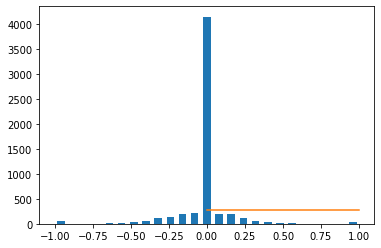

In [8]:
# plot steering angle of images on histogram visualizing is veru=y important to check irregularities in data

num_bins = 25 #(odd for cetral distribution)
samples_per_bin = 275
hist, bins = np.histogram(df['steering'], num_bins)#(steering values, divide them by no of bins) # returns 2 vals, values of histogram, interval of bins(steering angles)

#the center value of the data should be 0 and the distribution of steerng angles should be around it
center = (bins[:-1] + bins[1:])*0.5  #(starting at -1 till 0.92) + (starting at -0.92 to 1)(-0.04+0.04 = 0) 
# by doing the above middle neighbours are added and others are doubled, so finally we have to deivide them by 2 

print(center)
plt.bar(center, hist, width = 0.05)#(range of vals, vals of histogram, widhth of each bar)

# more zero angles as track was more centered, we dont want our model to be more biased to center driving so reduce the dataset by setting max threshold to approx 300
plt.plot(np.min(df['steering']),np.max(df['steering']), (samples_per_bin, samples_per_bin))#(min,max , x-samples per bin, y-samples per bin)

total_data: 5672
removed: 3876
remaining: 1796


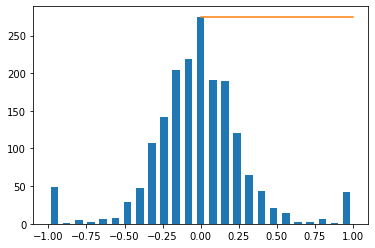

In [9]:

# remove all samples above the threshold
print('total_data:',len(df))
remove_list = []
for j in range(num_bins): #loop through the bins
  list_ = []
  for i in range(len(df)): #isolate streering data in a certain bin
  # if the steering angle at the index is greater than tthe current bin [j] && steering data if it is smaller than the bin that comes after the current one
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]: # condition  for checking  the steering angle
  # eg a value of -0.97 -0.96,-0.95 all belong to the same bin
      list_.append(i) 

  list_ = shuffle(list_) #part of outer loop
  list_=list_[samples_per_bin:] #(from the limit to above) #isolate the extra part of the list and put it in the empty remove list
  # we have to shuffle the list after every interval because if we have 500 instances of left steering angles and our limit is 300 we just cant reject the last 200 because these angles 
  #are in chronological order and we would lose the angles at the end of the track .They are from start to end hence shuffling is important to get uniform data from start to end.
  remove_list.extend(list_)

print('removed:',len(remove_list))
# now we will drop the data using the indices in this remove list from our actual df
df.drop(df.index[remove_list], inplace = True) # inplace = true so that the updated value stays on the same copy
print('remaining:',len(df))
hist, _ = np.histogram(df['steering'],(num_bins))#(,no of intervals)
#plotting
plt.bar(center, hist, width = 0.05)
plt.plot(np.min(df['steering']),np.max(df['steering']), (samples_per_bin, samples_per_bin))


In [10]:
# record recovery laps where we make seperate recording of the car constatntly steering from the side to recover


In [11]:
# TRAINING AND VALIDATION SPLIT
 # images as training data an steering angles as lables
print(df.iloc[1])
def load_image_steering(data_directory,df): 
   image_path = [] #X
   steering = []   #y
   for i in range(len(df)):
     index_data = df.iloc[i] #iloc allows us to do a selection on the row of data from the df based on the index
     center, left, right = index_data[0], index_data[1], index_data[1]
     #we are going to now take the center images and place them in the image list with the original path and convert it to an array so that it can be split into training and validation data#
     #NOTE that we have to add the full path of the images that are currently shortened
     image_path.append(os.path.join (data_directory,center.strip()))  #(join the directory with corresponding image name, .stip eliminates spaces if any in string )
     steering.append(float(index_data[3]))
   
   #conv list to arrays
   image_paths = np.asarray(image_path)   
   steerings = np.asarray(steering)

   return image_paths, steerings

image_paths,steerings =  load_image_steering(data_directory,df)

#split these in train and validation using a model from sklearn (train_test_split)




center      center_2023_02_13_14_28_30_025.jpg
left        left_2023_02_13_14_28_30_025.jpg  
right       right_2023_02_13_14_28_30_025.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000081                          
Name: 1, dtype: object


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6) #(X,y,split,random seed)
print('Training samples : {} \n Valid samples : {}'.format(len(X_train),len(X_valid)))


Training samples : 1436 
 Valid samples : 360


Text(0.5, 1.0, 'validation set')

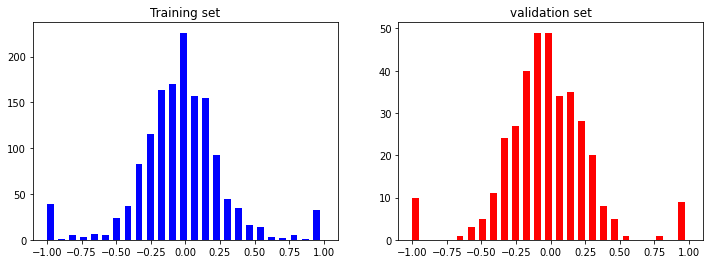

In [13]:
# Plot X_train and X_valid using subplots-2 outputs figs and axes 2 histograms one at index  and one at index 2
fig, axes = plt.subplots(1,2, figsize=(12,4))#(no of rows,cols,figsize)
axes[0].hist(y_train,bins = num_bins, width = 0.05,color = 'blue') #(plotting steering angles)
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins = num_bins, width = 0.05,color = 'red') #(plotting steering angles)
axes[1].set_title('validation set')



In [14]:
# both follow a general trend center bias seen

In [15]:
### PREPROCESSING IMAGES 
#we have the image paths so we have to now include and read the image from the path to preprocess

In [16]:
# we dont need to focus on a lot of features in the image as the top part is just scenery and bottom part is just the hood of the car
# so lets crop it as we know th image is a 3d array(height,width,channels)# as we want to reduce height we'll keep th other params default
#(to use the Nvidia architecture it is suggested to use yuv colorspace for our dataset as opposed to the deafault rgb format or even grayscale img )

def img_preprocess(img):
  img = mpimg.imread(img) #reading image from path
  img = img[60:135,:,:]
  cv2.cvtColor(img,cv2.COLOR_RGB2YUV) # yuv 3 channels - y(luminosty/brightness),u,v(chromium components which add colors to the image)
  #Gaussian blur for smoothening and reducing noise kernel convolution
  img = cv2.GaussianBlur(img, (3,3), 0)
  # resize to increase size for faster computation
  cv2.resize(img, (200,66)) #(image,size of image)
  #normalize(no visual immpact)
  img = img/255
  return img


In [17]:
# comparing original to  image to preprocessed image # define them independently
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


FileNotFoundError: ignored

In [ ]:
#Preprocessing the taining dataset

#using map fucntion to iterate through entire array. and for every element it loops though returns a new elements based on fucntion that is executed for each item in the array
# this essentially creates a new updated array with the modified items 

X_train = np.array(list(img_preprocess,X_train))#(fn,array) returns a list then convert it back to array using asarray

In [ ]:
# Veryfying whether the data is preprocessed or not by taking a random image from the dataset and viewing it

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])#(from 0 to len-1)
plt.axis("off")
print(X_train.shape)

In [ ]:
### NVIDIA MODEL ARCHITECTURE 

In [ ]:
def nvidia_model(): # cnvolutional != conv2d
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  #model.add(convolutional2D(24,5,5, subsamples(strides 2,2), input_shape(66,200,3, actiavation=)))

  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  # 3 more layers with changed attributes remove strides and reduce kernel size towards the end as image size reduces 
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  #flatten and input to fully connected layers
  model.add(Dense(100, activation='elu'))
  #Dropout in between DNN to reduce overfitting
  #0.5 - 50 percent of randomly selected nodes are turned off 
  model.add(Dropout(0.5))


  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5)) # new dropout for reducing overfitting

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5)) # new dropout for reducing overfitting

  #last layer with one noode
  model.add(Dense(1))

  # slow learning rate for efficient learning
  optimizer= Adam(1e-3)
  # regression model therefore mean square error loss to be calculated (poly reg module)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [ ]:
model = nvidia_model()
print(model.summary)

In [ ]:
history = model.fit(X_train,y_train, epochs =30, validation_data=(X_valid,y_valid), batch_size=100, verbose=1, shuffle=1)

In [ ]:
# # In training process our epochs are increasing but loss is not going down 
# # Relu is good for big computations, reliale and quick, but in this case the loss is not converging
# # relu can cause somethiing called ddead relu and only feeds 0 to the following nodes 
# if value is less than 0 if the value is greater than 0 the  that value is retuned.
# the gradient of relu in the posive direction is one but in the negative direction is 0
# therefore if a node gets an input of negative number it wil return 0 and as gradient at this point is zero the weight will never change as back propogation use gradient value to converge. 
# # hence the value will not reduce as back propogation will be zero so on so forth
#if many relus die this happepns  so use elu
#elu same in +ve region to relu but in -ve region will give a negative gradient value

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
#before applying the model to the simulator we need to save our model

In [ ]:
model.save('model.h5')

In [ ]:
#download model

In [ ]:
from google.colab import files

In [ ]:
files.download('model.h5') # may not work so save a copy in drive and re run it there then try it on google chrome